In [1]:
from __future__ import annotations
import numpy as np
import pandas as pd
from typing import Optional, Tuple, Union, Sequence, List
from abc import ABC, abstractmethod
import matplotlib.pyplot as plt
import inspect

class BaseSAAdapter(ABC):
    @abstractmethod
    def fit(self, X, y, time_col: str = "time", event_col: str = "event"): ...
    @abstractmethod
    def predict_survival_function(self, X, times: Optional[Sequence[float]] = None): ...
    @abstractmethod
    def predict_hazard_function(self, X, times: Optional[Sequence[float]] = None): ...
    @abstractmethod
    def predict_time(self,X): ...
    @abstractmethod
    def predict_proba(self, X): ...
    
    def timeWrap(self, y, time_col="time", event_col="event"):
        if isinstance(y, tuple) and len(y) == 2:
            t, e = y
            return np.asarray(t, float), np.asarray(e, bool)
        if isinstance(y, pd.DataFrame):
            return y[time_col].to_numpy(dtype=float), y[event_col].to_numpy(dtype=bool)
        if isinstance(y, dict):
            return np.asarray(y[time_col], float), np.asarray(y[event_col], bool)
        if isinstance(y, np.ndarray) and y.dtype.names:
            names = list(y.dtype.names)
            ev = next((n for n in names if n.lower().startswith(("event", "status"))), names[0])
            tm = next((n for n in names if n.lower().startswith(("time", "duration"))), names[-1])
            return y[tm].astype(float), y[ev].astype(bool)
        raise ValueError("Unsupported y format")
    
    @staticmethod
    def _has(obj, name): return hasattr(obj, name)

    def _get_proba(self, model, X) -> np.ndarray:
        if self._has(model, "predict_proba"):
            proba = model.predict_proba(X)
            if proba.ndim == 2 and proba.shape[1] >= 2:
                return proba[:, 1]
            return np.clip(np.ravel(proba), 0.0, 1.0)
        if self._has(model, "decision_function"):
            z = np.asarray(model.decision_function(X), float).ravel()
            return 1.0 / (1.0 + np.exp(-z))
        if self._has(model, "predict"):
            yhat = np.asarray(model.predict(X))
            if set(np.unique(yhat)).issubset({0, 1, False, True}):
                return yhat.astype(float)
            ymin, ymax = float(np.min(yhat)), float(np.max(yhat))
            if ymax > ymin:
                return np.clip((yhat - ymin) / (ymax - ymin), 0.0, 1.0)
            return np.zeros_like(yhat, dtype=float)
        n = len(X) if hasattr(X, "__len__") else 1
        return np.full(n, 0.5, float)


class ClassifWrapSA(BaseSAAdapter):
    def __init__(self, model, times: int = 128, start_at_zero: bool = True):
        self.model = model
        self.times = times
        self.start_at_zero = start_at_zero
        self._bounds: Optional[Tuple[float, float]] = None
    def fit(self, X, y, time_col: str = "time", event_col: str = "event"):
        t, e = self.timeWrap(y, time_col, event_col)
        left = float(np.min(t))
        right = float(np.max(t))
        if not np.isfinite(left) or not np.isfinite(right) or left >= right:
            left = 0.0
            right = 1.0
        self._bounds = (left, right)
        self.model.fit(X, e.astype(int))
        return self
    def predict_proba(self, X):
        proba = self._get_proba(self.model, X)
        if proba.ndim == 1:
            proba = np.column_stack([1 - proba, proba])
        return proba
    def predict_survival_function(self, X, times = None):
        assert self._bounds is not None, "Call fit() first"
        if times is not None:
            t = np.asarray(times, float)
        else:
            left, right = self._bounds
            start = 0.0 if self.start_at_zero else left
            t = np.linspace(start, right, self.times) #разбивает на равномерную сетку
        p = self._get_proba(self.model, X)
        S = np.tile((1.0-p)[:, None], (1,t.size)) #матрица выживаемости dim(p)*t.size
        return S, t
    def predict_hazard_function(self, X, times=None):
        S, t = self.predict_survival_function(X, times)
        eps = 1e-12
        H = -np.log(np.clip(S, eps, 1.0))   # кумулятивная hazard, константна по t
        return H, t

    def predict_time(self, X):
        n = len(X) if hasattr(X, "__len__") else self.predict_proba(X).shape[0]
        return np.full(n, np.nan, float)
class RegrWrapSA(BaseSAAdapter):
    def __init__(self, model, times: int = 128, start_at_zero: bool = True):
        self.model = model
        self.times = times
        self.start_at_zero = start_at_zero
        self._bounds: Optional[Tuple[float, float]] = None
    def fit(self, X, y, time_col: str = "time", event_col: str = "event"):
        t, _ = self.timeWrap(y, time_col, event_col)
        left = float(np.min(t))
        right = float(np.max(t))
        if not np.isfinite(left) or not np.isfinite(right) or left >= right:
            left = 0.0
            right = 1.0
        self._bounds = (left, right)
        self.model.fit(X, t.astype(float))
        return self
    def predict_time(self, X):
        return np.asarray(self.model.predict(X), float)
    def predict_survival_function(self, X, times = None):
        assert self._bounds is not None, "Call fit() first"
        if times is not None:
            t = np.asarray(times, float)
        else:
            left, right = self._bounds
            start = 0.0 if self.start_at_zero else left
            t = np.linspace(start, right, self.times) #разбивает на равномерную сетку
        T = self.predict_time(X)[:, None]
        S = (t[None, :] < T).astype(float)
        return S, t
    def predict_hazard_function(self, X, times = None):
        S, t = self.predict_survival_function(X, times)
        eps = 1e-12
        H = -np.log(np.clip(S, eps, 1.0))  # кумулятивная hazard
        return H, t
    def predict_proba(self, X):
        S, _ = self.predict_survival_function(X)
        p = 1.0 - S[:, -1]
        return np.column_stack([1.0 - p, p])
    def predict(self, X):
        return self.model.predict(X)
class SAWrapSA(BaseSAAdapter):
    def __init__(self, model, times: int = 128, start_at_zero: bool = True):
        self.model = model
        self.times = times
        self.start_at_zero = start_at_zero
        self._bounds: Optional[Tuple[float, float]] = None
        self._kind = model.__class__.__module__
    @staticmethod
    def _make_structured_y(t, e):
        return np.array(list(zip(e.astype(bool), t.astype(float))), dtype=[('event','?'),('time','<f8')])
    
    def fit(self, X, y, time_col: str = "time", event_col: str = "event"):
        t, e = self.timeWrap(y, time_col, event_col)
        left = float(np.min(t))
        right = float(np.max(t))
        if not np.isfinite(left) or not np.isfinite(right) or left >= right:
            left = 0.0
            right = 1.0
        self._bounds = (left, right)
        if "lifelines" in self._kind:
            fit_sig = inspect.signature(self.model.fit)
            params = fit_sig.parameters
            if "duration_col" in params: #двумерные, например CoxPHFitter
                df = pd.DataFrame(X if isinstance(X, pd.DataFrame) else np.asarray(X)).copy()
                df[time_col] = t
                df[event_col] = e.astype(int)
                self.model.fit(df, duration_col=time_col, event_col=event_col)
            else: #одномерные, например NelsonAalenFitter
                if "durations" in params:
                    self.model.fit(durations=t, event_observed=e.astype(int))
                else:
                    self.model.fit(t, e.astype(int))
        elif self._kind.startswith("sksurv.") or "sksurv" in self._kind:
            self.model.fit(X, self._make_structured_y(t, e))
        elif "survivors" in self._kind:
            self.model.fit(X, y)
        else:
            self.model.fit(X, y)
        return self
    def predict_survival_function(self, X, times = None):
        assert self._bounds is not None, "Call fit() first"
        if times is not None:
            t = np.asarray(times, float)
        else:
            left, right = self._bounds
            start = 0.0 if self.start_at_zero else left
            t = np.linspace(start, right, self.times) #разбивает на равномерную сетку
        if "lifelines" in self._kind:
            n = len(X) if hasattr(X, "__len__") else 1
            if hasattr(self.model, "predict_survival_function"): #двумерны
                df = X if isinstance(X, pd.DataFrame) else pd.DataFrame(X)
                sf = self.model.predict_survival_function(df)
                if isinstance(sf, list):
                    S = np.vstack([np.interp(t, s.index.values.astype(float), np.asarray(s).astype(float)) for s in sf])
                else:   #одномерные
                    idx = sf.index.values.astype(float)
                    S = np.vstack([np.interp(t, idx, sf.iloc[:, i].values.astype(float)) for i in range(sf.shape[1])])
                return S, t
            #одномерные 
            if hasattr(self.model, "survival_function_at_times"):
                s = self.model.survival_function_at_times(t)
                s_vals = np.asarray(s).astype(float).ravel()
            elif hasattr(self.model, "cumulative_hazard_at_times"):
                H = self.model.cumulative_hazard_at_times(t)
                H_vals = np.asarray(H).astype(float).ravel()
                s_vals = np.exp(-H_vals)
            else:
                raise RuntimeError("lifelines univariate model without at_times methods")
            S = np.tile(s_vals[None, :], (n, 1))
            return S, t
        elif self._kind.startswith("sksurv.") or "sksurv" in self._kind:
            s = self.model.predict_survival_function(X)
            S = np.vstack([sf(t) for sf in s])
            return S, t
        elif "survivors" in self._kind:
            if times is not None:
                t = np.asarray(times, float)
            else:
                left, right = self._bounds
                start = 0.0 if self.start_at_zero else left
                t = np.linspace(start, right, self.times)
            S = np.asarray(self.model.predict_at_times(X, t, mode="surv"), float)
            if S.ndim == 1:
                S = S[None, :]
            elif S.shape[1] != t.shape[0] and S.shape[0] == t.shape[0]:
                S = S.T
            return S, t
        raise RuntimeError("Model does not provide survival predictions")
        
    def predict_hazard_function(self, X, times = None):
        assert self._bounds is not None, "Call fit() first"
        if "lifelines" in self._kind:
            if times is not None:
                t = np.asarray(times, float)
            else:
                left, right = self._bounds
                start = 0.0 if self.start_at_zero else left
                t = np.linspace(start, right, self.times) #разбивает на равномерную сетку
            n = len(X) if hasattr(X, "__len__") else 1
            if hasattr(self.model, "predict_cumulative_hazard"): #двумерны
                df = X if isinstance(X, pd.DataFrame) else pd.DataFrame(X)
                ch = self.model.predict_cumulative_hazard(df)
                if isinstance(ch, list):
                    H = np.vstack([np.interp(t, h.index.values.astype(float), np.asarray(h).astype(float)) for h in ch])
                else:
                    idx = ch.index.values.astype(float)
                    H = np.vstack([np.interp(t, idx, ch.iloc[:, i].values.astype(float)) for i in range(ch.shape[1])])
                return H, t
            if hasattr(self.model, "cumulative_hazard_at_times"): #одномерные
                H_single = self.model.cumulative_hazard_at_times(t)
                H_vals = np.asarray(H_single).astype(float)
                H_vals = np.ravel(H_vals)
                H = np.tile(H_vals[None, :], (n, 1))
                return H, t
            S, t = self.predict_survival_function(X, t)
            eps = 1e-12
            H = -np.log(np.clip(S, eps, 1.0))
            return H, t
        if "survivors" in self._kind:
            if times is not None:
                t = np.asarray(times, float)
            else:
                left, right = self._bounds
                start = 0.0 if self.start_at_zero else left
                t = np.linspace(start, right, self.times)
            H = np.asarray(self.model.predict_at_times(X, t, mode="hazard"), float)
            if H.ndim == 1:
                H = H[None, :]
            elif H.shape[1] != t.shape[0] and H.shape[0] == t.shape[0]:
                H = H.T
            return H, t

        S, t = self.predict_survival_function(X, times) #для всех других моделей
        eps = 1e-12
        H = -np.log(np.clip(S, eps, 1.0))
        return H, t
    
    def predict_time(self, X):
        S, t = self.predict_survival_function(X)
        med = np.full(S.shape[0], np.nan, float)
        for i, row in enumerate(S):
            j = np.argmax(row <= 0.5)
            if row[j] <= 0.5:
                med[i] = t[j]
        return med
    def predict_proba(self, X):
        S, _ = self.predict_survival_function(X)
        p = 1.0 - S[:, -1]
        return np.column_stack([1.0 - p, p])

def plot_many(models, X, sample: int = 0, times: Optional[Sequence[float]] = None, title="Survival curves comparison", mode: str = "survival"):
    if times is not None:
        t_common = np.asarray(times, float)
    else:
        t_max = 1.0
        for m in models:
            if m._bounds is not None:
                t_max = max(t_max, m._bounds[1])
        t_common = np.linspace(0.0, t_max, 128)
    X_i = X.iloc[[sample]] if isinstance(X, pd.DataFrame) else np.asarray(X)[[sample], :]
    plt.figure(figsize=(7, 5))
    for m in models:
        name = type(m.model).__name__
        if mode.lower().startswith("h"):
            S, _ = m.predict_hazard_function(X_i, t_common)
            ylabel = "Hazard H(t)"
        else:
            S, _ = m.predict_survival_function(X_i, t_common)
            ylabel = "Survival S(t)"
        plt.plot(t_common, S[0], label=name)
    plt.xlabel("Time")
    plt.ylabel("Survival S(t)")
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.show()
    




In [2]:
X = pd.DataFrame({"age":[60,55,70,50], "stage":[2,1,3,2]})
time  = np.array([5, 7, 3, 12], float)
event = np.array([1, 0, 1,  1], bool)
y = (time, event)

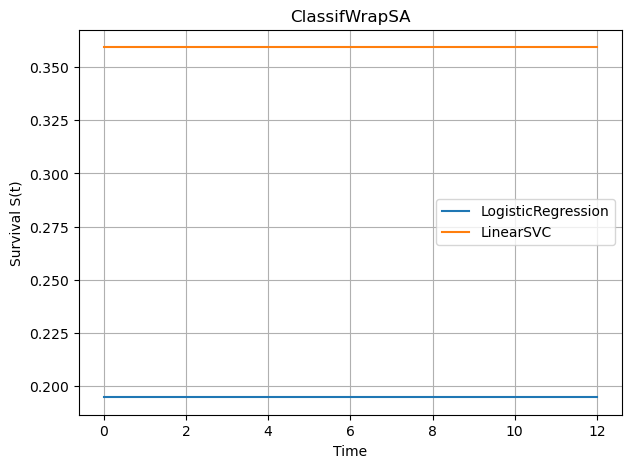

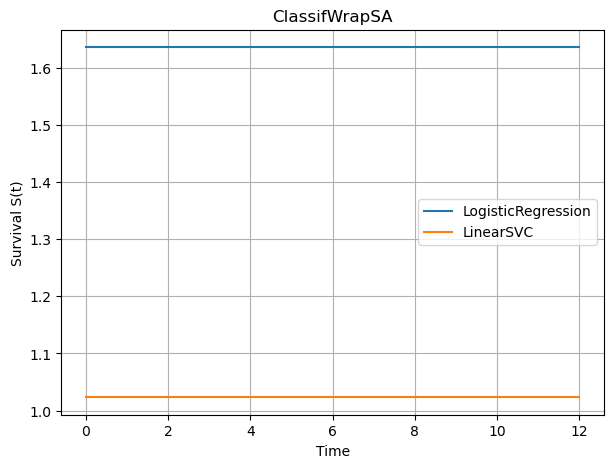

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
m_cls1 = ClassifWrapSA(LogisticRegression()).fit(X, y)
m_cls2 = ClassifWrapSA(LinearSVC()).fit(X, y)
plot_many([m_cls1, m_cls2], X, sample=0, title="ClassifWrapSA")
plot_many([m_cls1, m_cls2], X, sample=0, title="ClassifWrapSA", mode="hazard")

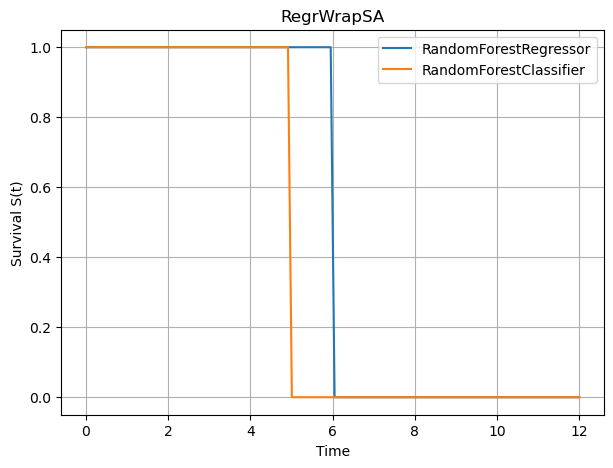

In [4]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
m_reg1 = RegrWrapSA(RandomForestRegressor()).fit(X, y)
m_reg2 = RegrWrapSA(RandomForestClassifier()).fit(X, y)
plot_many([m_reg1, m_reg2], X, sample=0, title="RegrWrapSA")

In [5]:
from metrics_sa import eval_classification_model, print_metrics, eval_regression_model
metrics = eval_regression_model(m_reg1, X, time)
print_metrics(metrics, "RandomForestRegressor")

RandomForestRegressor
mse         : 1.6787
rmse        : 1.2956
mae         : 1.2400
r2          : 0.8500


d:\Users\DimonZhi\anaconda3\Lib\site-packages\lifelines\utils\__init__.py:1163: ConvergenceWarning: Column age has high sample correlation with the duration column. This may harm convergence. This could be a form of 'complete separation'.     See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression

  warnings.warn(dedent(warning_text), ConvergenceWarning)
d:\Users\DimonZhi\anaconda3\Lib\site-packages\lifelines\fitters\coxph_fitter.py:1607: ConvergenceWarning: Newton-Raphson convergence completed successfully but norm(delta) is still high, 0.946. This may imply non-unique solutions to the maximum likelihood. Perhaps there is collinearity or complete separation in the dataset?

  warnings.warn(


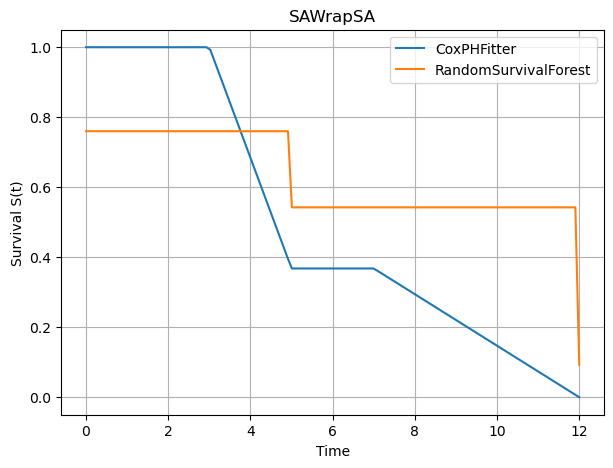

In [6]:
from lifelines import CoxPHFitter
from sksurv.ensemble import RandomSurvivalForest
m_sa1 = SAWrapSA(CoxPHFitter()).fit(X, y)
m_sa2 = SAWrapSA(RandomSurvivalForest(n_estimators=100, random_state=0)).fit(X, y)
plot_many([m_sa1, m_sa2], X, sample=0, title="SAWrapSA")

In [7]:
metrics = eval_classification_model(m_sa1, X, event)
print_metrics(metrics, "CoxPHFitter_classif")
metrics = eval_classification_model(m_sa2, X, event)
print_metrics(metrics, "RandomSurvivalForest_classif")

CoxPHFitter_classif
accuracy    : 0.7500
f1          : 0.8571
roc_auc     : 0.6667
log_loss    : 0.4425
brier       : 0.1673
RandomSurvivalForest_classif
accuracy    : 0.7500
f1          : 0.8571
roc_auc     : 0.5000
log_loss    : 0.6679
brier       : 0.2123


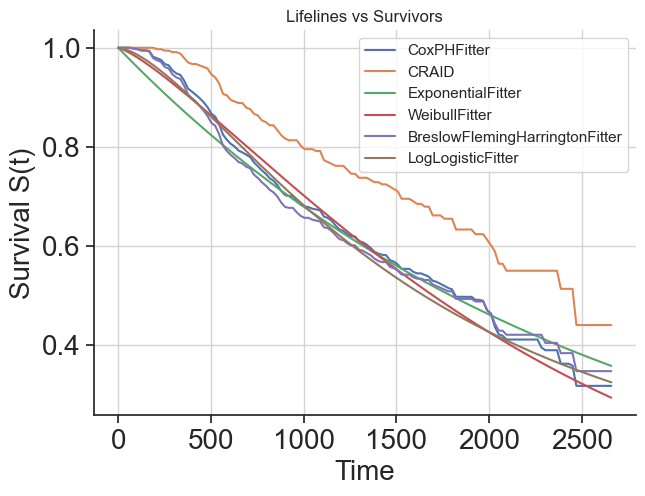

In [8]:
from lifelines import CoxPHFitter, ExponentialFitter, WeibullFitter, BreslowFlemingHarringtonFitter, LogLogisticFitter, SplineFitter
import survivors.datasets as ds
from survivors.tree import CRAID

X, y, features, categ, sch_nan = ds.load_gbsg_dataset()

cr = CRAID(criterion='wilcoxon', depth=2, min_samples_leaf=0.1,
           signif=0.05, categ=categ, leaf_model="base")

m_sa1 = SAWrapSA(CoxPHFitter()).fit(X, y)
m_sa2 = SAWrapSA(cr).fit(X, y)
m_sa3 = SAWrapSA(ExponentialFitter()).fit(X, y)
m_sa4 = SAWrapSA(WeibullFitter()).fit(X, y)
m_sa5 = SAWrapSA(BreslowFlemingHarringtonFitter()).fit(X, y)
m_sa6 = SAWrapSA(LogLogisticFitter()).fit(X, y)

plot_many([m_sa1, m_sa2, m_sa3, m_sa4, m_sa5, m_sa6], X, sample=0, title="Lifelines vs Survivors")

In [9]:
event = y["cens"]
y_event = event.astype(int)
metrics = eval_classification_model(m_sa1, X, y_event)
print_metrics(metrics, "CoxPHFitter")
metrics = eval_classification_model(m_sa2, X, y_event)
print_metrics(metrics, "CRAID")
metrics = eval_classification_model(m_sa3, X, y_event)
print_metrics(metrics, "ExponentialFitter")
metrics = eval_classification_model(m_sa4, X, y_event)
print_metrics(metrics, "WeibullFitter")
metrics = eval_classification_model(m_sa5, X, y_event)
print_metrics(metrics, "BreslowFlemingHarringtonFitter")
metrics = eval_classification_model(m_sa6, X, y_event)
print_metrics(metrics, "LogLogisticFitter")

CoxPHFitter
accuracy    : 0.5350
f1          : 0.6338
roc_auc     : 0.6842
log_loss    : 0.8050
brier       : 0.2782
CRAID
accuracy    : 0.4359
f1          : 0.6071
roc_auc     : 0.6611
log_loss    : 0.7456
brier       : 0.2722
ExponentialFitter
accuracy    : 0.4359
f1          : 0.6071
roc_auc     : 0.5000
log_loss    : 0.7738
brier       : 0.2889
WeibullFitter
accuracy    : 0.4359
f1          : 0.6071
roc_auc     : 0.5000
log_loss    : 0.8445
brier       : 0.3197
BreslowFlemingHarringtonFitter
accuracy    : 0.4359
f1          : 0.6071
roc_auc     : 0.5000
log_loss    : 0.7837
brier       : 0.2934
LogLogisticFitter
accuracy    : 0.4359
f1          : 0.6071
roc_auc     : 0.5000
log_loss    : 0.8069
brier       : 0.3038


In [ ]:
from metrics_sa import eval_survival_model, print_metrics
from sklearn.model_selection import train_test_split

X_tr, X_tst, y_tr, y_tst = train_test_split(X, y, test_size=0.5)

m_sa1 = SAWrapSA(CoxPHFitter()).fit(X_tr, y_tr)
m_sa2 = SAWrapSA(cr).fit(X_tr, y_tr)
m_sa3 = SAWrapSA(ExponentialFitter()).fit(X_tr, y_tr)
m_sa4 = SAWrapSA(WeibullFitter()).fit(X_tr, y_tr)
m_sa5 = SAWrapSA(BreslowFlemingHarringtonFitter()).fit(X_tr, y_tr)
m_sa6 = SAWrapSA(LogLogisticFitter()).fit(X_tr, y_tr)

print_metrics(eval_survival_model(m_sa1, X_tr, y_tr, X_tst, y_tst), "CoxPHFitter")
print_metrics(eval_survival_model(m_sa2,  X_tr, y_tr, X_tst, y_tst), "CRAID")
print_metrics(eval_survival_model(m_sa3, X_tr, y_tr, X_tst, y_tst), "ExponentialFitter")
print_metrics(eval_survival_model(m_sa4,  X_tr, y_tr, X_tst, y_tst), "WeibullFitter")
print_metrics(eval_survival_model(m_sa5, X_tr, y_tr, X_tst, y_tst), "BreslowFlemingHarringtonFitter")
print_metrics(eval_survival_model(m_sa6,  X_tr, y_tr, X_tst, y_tst), "LogLogisticFitter")

CoxPHFitter
c_index     : 0.5022
ibs_remain  : 0.1737
auprc       : 0.5899
CRAID
c_index     : 0.4777
ibs_remain  : 0.1849
auprc       : 0.5846
ExponentialFitter
c_index     : 0.5000
ibs_remain  : 0.2089
auprc       : 0.5303
WeibullFitter
c_index     : 0.5000
ibs_remain  : 0.1990
auprc       : 0.5613
BreslowFlemingHarringtonFitter
c_index     : 0.5000
ibs_remain  : 0.2050
auprc       : 0.5544
LogLogisticFitter
c_index     : 0.5000
ibs_remain  : 0.1994
auprc       : 0.5568


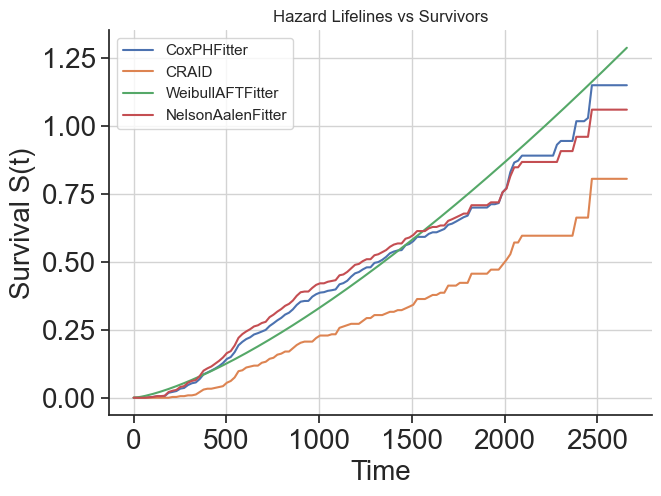

In [11]:
from lifelines import CoxPHFitter, NelsonAalenFitter, WeibullAFTFitter
import survivors.datasets as ds
from survivors.tree import CRAID

X, y, features, categ, sch_nan = ds.load_gbsg_dataset()

cr = CRAID(criterion='wilcoxon', depth=2, min_samples_leaf=0.1,
           signif=0.05, categ=categ, leaf_model="base")

m_sa1 = SAWrapSA(CoxPHFitter()).fit(X, y)
m_sa2 = SAWrapSA(cr).fit(X, y)
m_sa3 = SAWrapSA(WeibullAFTFitter()).fit(X,y)
m_sa4 = SAWrapSA(NelsonAalenFitter()).fit(X,y)

plot_many([m_sa1, m_sa2, m_sa3, m_sa4], X, sample=0, mode="hazard", title="Hazard Lifelines vs Survivors")